In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import yaml
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import Image, display
from typing import List

In [2]:
# Experiments to visualize
exp_names = [
    "demo",
]

In [3]:
from utils.eval_utils import EditResultData

# Load all results
eval_dirs = sum([sorted([p for p in Path(f"result/{exp_name}").glob("*/") if p.is_dir()]) for exp_name in exp_names], [])
edit_results = [EditResultData.from_metrics(eval_dir, skip_img_load=True) for eval_dir in eval_dirs]

/opt/conda/envs/diffinv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_metrics(edit_results: List[EditResultData]) -> pd.DataFrame:
    """Creates a pandas Dataframe for all experiments

    Args:
        edit_results (List[EditResultData]): Experiment results

    Returns:
        pd.DataFrame Results as pandas dataframe
    """

    data = []

    for r in tqdm(edit_results):
        method_cfg = {**r.method}

        metrics = {
            "data": str(r.data),
            "exp_name": r.exp_name,
            "method": method_cfg.pop("type"),
            "scheduler": method_cfg.pop("scheduler"),
            "steps": method_cfg.pop("num_inference_steps", 50),
            "edit_method": r.edit_method["type"],
            "method_cfg": method_cfg,
            **{k: v["mean"] for k, v in r.metrics.items()},
        }

        data.append(metrics)

    print(data)

    return pd.DataFrame(data)

df = get_metrics(edit_results)
df

100%|██████████| 4/4 [00:00<00:00, 23237.14it/s]

[{'data': 'pie', 'exp_name': 'result_demo', 'method': 'diffinv', 'scheduler': 'ddim', 'steps': 50, 'edit_method': 'simple', 'method_cfg': {}, 'clip_text_text': 0.7974388798077902, 'ssim': 0.4563397765159607, 'clip_text_img': 0.31860673427581787, 'clip_img_img': 0.8722811937332153, 'clip_text_img_acc': 1.0, 'clip_text_text_acc': 1.0, 'dinov2_vitb14': 0.011118485902746519, 'nslpips': 0.46805421511332196, 'lpips': 0.4944816728432973, 'clip_textdir_imgdir': 0.0712335283557574, 'bglpips': 0.3035563826560974, 'msssim': 0.5611560841401418, 'dino_vitb8': 0.06991693874200185}, {'data': 'pie', 'exp_name': 'result_demo', 'method': 'npi', 'scheduler': 'ddim', 'steps': 50, 'edit_method': 'simple', 'method_cfg': {}, 'clip_text_text': 0.6885488231976827, 'ssim': 0.4788840115070343, 'clip_text_img': 0.31169700622558594, 'clip_img_img': 0.7901085217793783, 'clip_text_img_acc': 1.0, 'clip_text_text_acc': 1.0, 'dinov2_vitb14': 0.013055483189721903, 'nslpips': 0.5440122485160828, 'lpips': 0.57440429925918

,data,exp_name,method,scheduler,steps,edit_method,method_cfg,clip_text_text,ssim,clip_text_img,clip_img_img,clip_text_img_acc,clip_text_text_acc,dinov2_vitb14,nslpips,lpips,clip_textdir_imgdir,bglpips,msssim,dino_vitb8
0,pie,result_demo,diffinv,ddim,50,simple,{},0.797439,0.456340,0.318607,0.872281,1.0,1.0,0.011118,0.468054,0.494482,0.071234,0.303556,0.561156,0.069917
1,pie,result_demo,npi,ddim,50,simple,{},0.688549,0.478884,0.311697,0.790109,1.0,1.0,0.013055,0.544012,0.574404,0.080649,0.339636,0.489531,0.090269
2,pie,result_demo,diffinv,ddim,50,ptp,{},0.771639,0.495869,0.316145,0.899713,1.0,1.0,0.009071,0.422164,0.441813,0.058369,0.282758,0.607758,0.055261
3,pie,result_demo,npi,ddim,50,ptp,{},0.844387,0.721197,0.318155,0.920718,1.0,1.0,0.004731,0.191446,0.210292,0.058534,0.100006,0.854436,0.018452


In [5]:
def get_metrics_per_image_single(exp: EditResultData) -> pd.DataFrame:
    """Get per image metrics for one experiment

    Args:
        exp (EditResultData): Result object to retrieve per image metrics for

    Returns:
        pd.DataFrame: Dataframe
    """

    out = []
    for i in range(len(exp)):
        sample = exp[i]
        out.append({
            **{k: sample[k] for k in ("image_file", "edit_image_file", "source_prompt", "target_prompt")},
            **sample["metrics"],
            "method": exp.method,
            "edit_method": exp.edit_method,
        })

    if len(out) == 0:
        return None

    out = pd.DataFrame(out)

    return out

def get_metrics_per_image(edit_results: List[EditResultData]) -> pd.DataFrame:
    """Get per image metrics for multiple experiment

    Args:
        edit_results (List[EditResultData]): Result objects to retrieve per image metrics for

    Returns:
        pd.DataFrame: Dataframes
    """
    
    out = [get_metrics_per_image_single(exp) for exp in edit_results]
    out = pd.concat([o for o in out if o is not None])

    return out

df_per_img = get_metrics_per_image(edit_results[:1])
df_per_img

,image_file,edit_image_file,source_prompt,target_prompt,clip_text_text,ssim,clip_text_img,clip_img_img,clip_text_img_acc,clip_text_text_acc,dinov2_vitb14,nslpips,lpips,clip_textdir_imgdir,bglpips,msssim,dino_vitb8,method,edit_method
0,data/eval/PIE-Bench_v1/annotation_images/0_ran...,result/demo/00_pie_test3_None_simple_ddim_diff...,a slanted mountain bicycle on the road in fron...,a slanted rusty mountain bicycle on the road i...,0.776787,0.371835,0.283691,0.874583,1.0,1.0,0.011620,0.425677,0.438004,0.032718,0.212361,0.471115,0.100911,"{'scheduler': 'ddim', 'type': 'diffinv'}",{'type': 'simple'}
1,data/eval/PIE-Bench_v1/annotation_images/0_ran...,result/demo/00_pie_test3_None_simple_ddim_diff...,a round cake with orange frosting on a wooden ...,a square cake with orange frosting on a wooden...,0.749593,0.446331,0.352990,0.869558,1.0,1.0,0.010656,0.554321,0.586512,0.046991,0.422424,0.551759,0.048990,"{'scheduler': 'ddim', 'type': 'diffinv'}",{'type': 'simple'}
2,data/eval/PIE-Bench_v1/annotation_images/0_ran...,result/demo/00_pie_test3_None_simple_ddim_diff...,a cat sitting on a wooden chair,a dog sitting on a wooden chair,0.865936,0.550853,0.319139,0.872703,1.0,1.0,0.011080,0.424165,0.458929,0.133992,0.275885,0.660595,0.059850,"{'scheduler': 'ddim', 'type': 'diffinv'}",{'type': 'simple'}


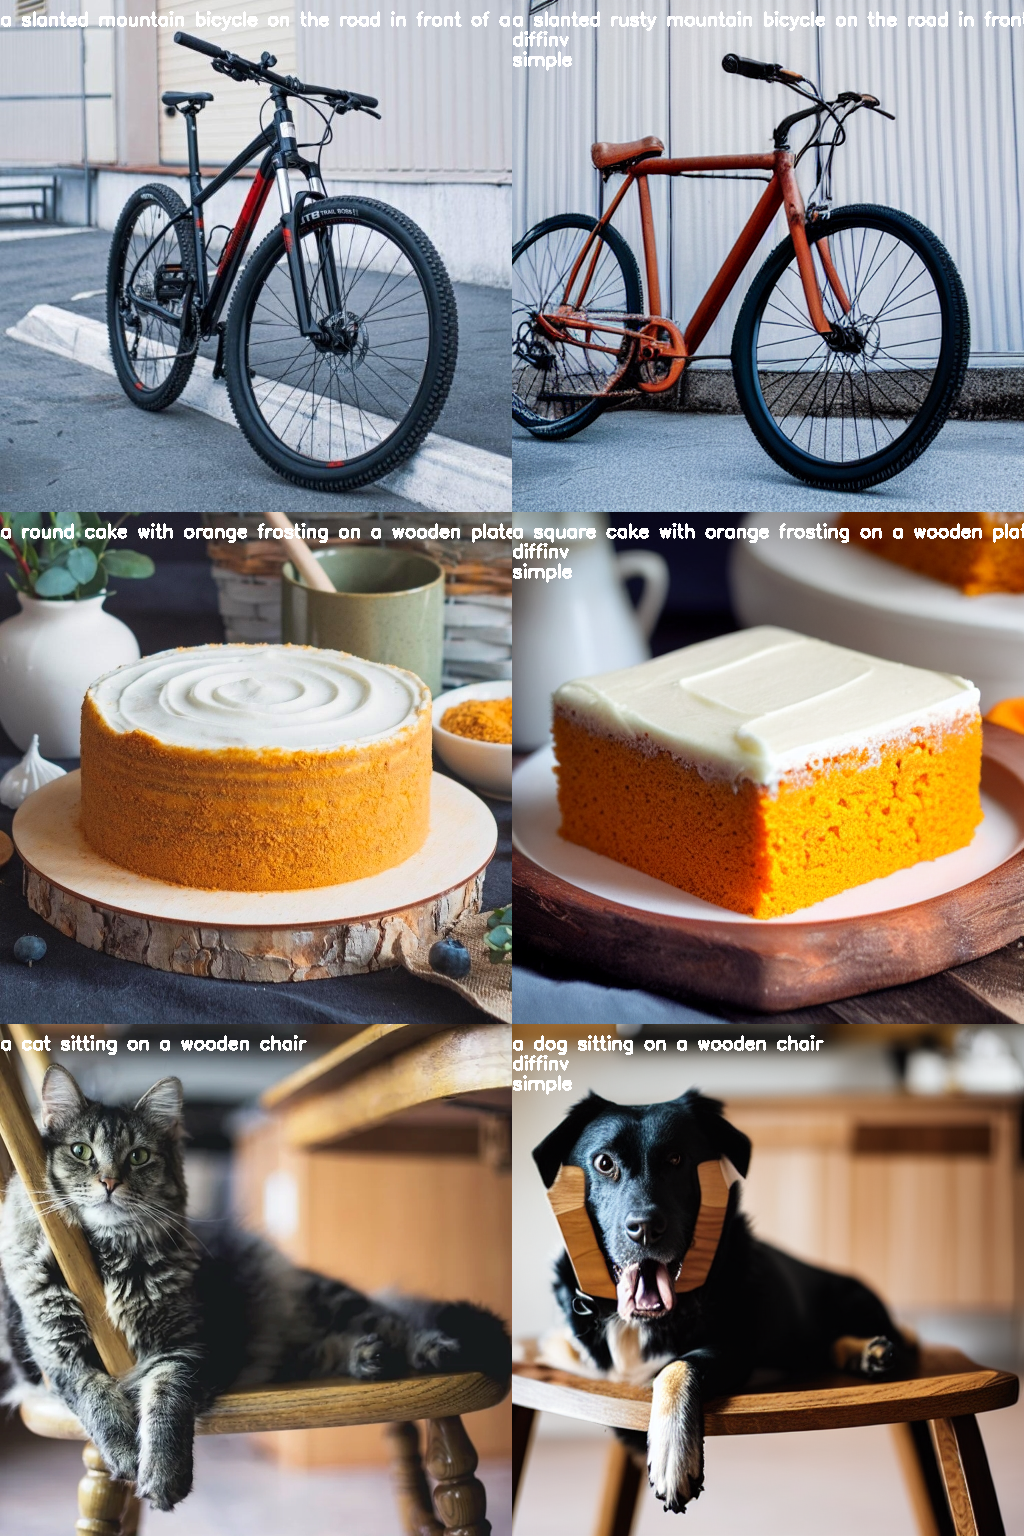

In [6]:
from utils.vis_utils import img_grid

def show_grid(entrys: pd.DataFrame, topk: int=5) -> "DisplayHandle":
    """Display a image grid of per image results.

    Args:
        entrys (pd.DataFrame): Per image dataframe
        topk (int, optional): How many entries to visualize. Defaults to 5.

    Returns:
        DisplayHandle: Image for notebook display
    """

    rows = []
    rows_titles = []

    def create_row(entry):
        rows.append([str(entry.image_file), str(entry.edit_image_file)])
        rows_titles.append([entry.source_prompt, "\n".join([entry.target_prompt, entry.method["type"], entry.edit_method["type"]])])

    for i in range(topk):
        create_row(entrys.iloc[i])

    out = img_grid(rows, rows_titles)
    return display(Image(cv2.imencode(".png", out)[1]))

show_grid(df_per_img, 3)